# Урок 3. Связь бизнес-показателей и DS-метрик  
  
  
**Домашнее задание:**  
1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта  
2. при обучении моделей обязательно использовать кроссвалидацию  
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)  
4. сделать выводы о том, какая модель справилась с задачей лучше других  
5. (опциональный вопрос) какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000).  
  
p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:  
  
Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).  
Допустим, у нас две модели:  
  
первая помечает 100 объектов как класс 1, но TP = 90  
вторая помечает 1000 объектов как класс 1, но TP такой же - 90  
Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?  
  
Ссылки  
https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/  
https://en.wikipedia.org/wiki/Receiver_operating_characteristic  

**Импорты:**

In [22]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

import itertools
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion

In [ ]:
bootstrapbool, default=True
Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

oob_scorebool, default=False
Whether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap=True.

#### **Функции:**

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
def get_cross_validation_scores(classifier, X_train, y_train, cv=16, scoring='roc_auc'):
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'CV score is {cv_score} +- {cv_score_std}')
    return cv_score, cv_score_std

In [94]:
def show_precision_recall_plot(y_test, y_pred, model_name: str, b: int = 1):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(f"Best Threshold = {thresholds[ix]}, "
          f'F-Score = {fscore[ix]:.3f}, '
          f'Precision = {precision[ix]:.3f}, '
          f"Recall = {recall[ix]:.3f}")
    
    plt.figure(figsize=(7, 7))
    plt.plot(precision, recall)
    plt.xlabel('precision')
    plt.ylabel('recall')
    plt.title(f'Precision - Recall plot ({model_name})')
    plt.show()
    return precision, recall, thresholds, fscore, ix

In [67]:
def get_roc_curve(y_test, y_pred, model_name: str):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(7, 7))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_pred, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve ({classifier})')
    plt.savefig("ROC.png")
    plt.show()

In [101]:
def show_conf_matrix(y_test, y_pred, thresholds):
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_pred>thresholds)
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Nontoxic', 'toxic'],
                          title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()
    return cnf_matrix

## Препроцессинг данных:

In [2]:
df = pd.read_csv('./materials/train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [7]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [8]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

## Построение моделей:

In [132]:
# Инициализирую словарь для финального датафрейма-сравнения. Колонки - метрики, строки - модели
final_comparison = {'models': ['Logistic Regression', 'Decision Tree Classifier', 'Random Forest', 'Gradient Boosting'],
                    'precision': [0 for _ in range(4)], 
                    'recall': [0 for _ in range(4)], 
                    'roc_auc': [0 for _ in range(4)], 
                    'f_score': [0 for _ in range(4)]}

In [103]:
classifier_logreg = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

classifier_dtc = Pipeline([
    ('features',feats),
    ('classifier', DecisionTreeClassifier(random_state = 42)),
])

classifier_randfor = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

classifier_gradboost = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

classifiers = {'Logistic Regression': classifier_logreg, 
               'Decision Tree Classifier': classifier_dtc, 
               'Random Forest': classifier_randfor, 
               'Gradient Boosting': classifier_gradboost}

## Logistic Regression

CV score is 0.7867401104915408 +- 0.00852135511666111
Best Threshold = 0.3869370891147379, F-Score = 0.730, Precision = 0.647, Recall = 0.838


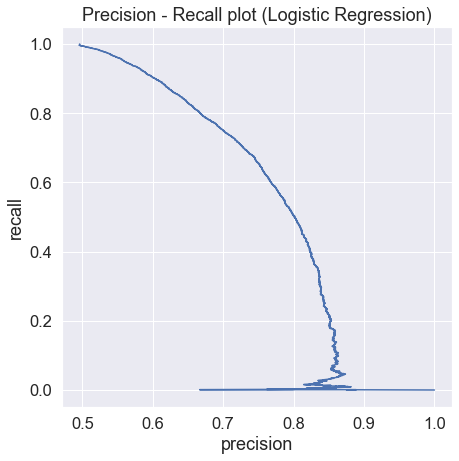

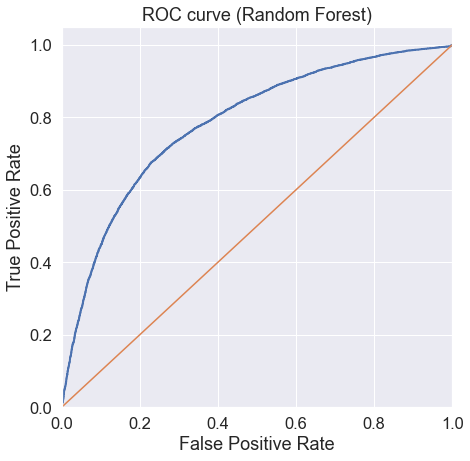

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


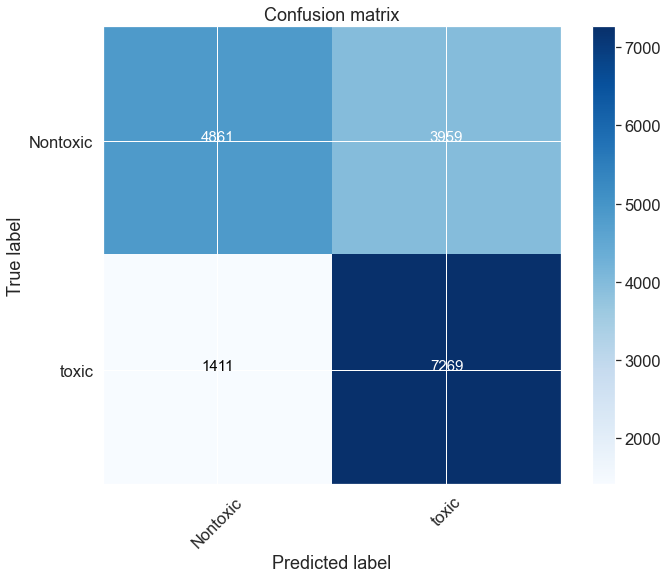

In [133]:
model_name = 'Logistic Regression'
model_index = 0
model = classifiers[model_name]

#запустим кросс-валидацию
cv_score, cv_score_std = get_cross_validation_scores(model, X_train, y_train, cv=16, scoring='roc_auc')

#обучим пайплайн на всем тренировочном датасете
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

# выведем precision/recall plot
precision, recall, thresholds, f_score, ix = show_precision_recall_plot(y_test.values, y_pred, model_name)

# выведем roc_curve
get_roc_curve(y_test, y_pred, model_name)

# выведем матрицу ошибок
cnf_matrix = show_conf_matrix(y_test, y_pred, thresholds[ix])

# соберем всю статистику по модели в словарь
final_comparison['precision'].insert(model_index, round(precision[ix], 4))
final_comparison['precision'].pop(model_index+1)
final_comparison['recall'].insert(model_index, round(recall[ix], 4))
final_comparison['recall'].pop(model_index+1)
final_comparison['roc_auc'].insert(model_index, round(roc_auc_score(y_test, y_pred), 4))
final_comparison['roc_auc'].pop(model_index+1)
final_comparison['f_score'].insert(model_index, round(f_score[ix], 4))
final_comparison['f_score'].pop(model_index+1);

## Decision Tree Classifier

CV score is 0.633725997143872 +- 0.00979859452710677
Best Threshold = 0.0, F-Score = 0.663, Precision = 0.496, Recall = 1.000


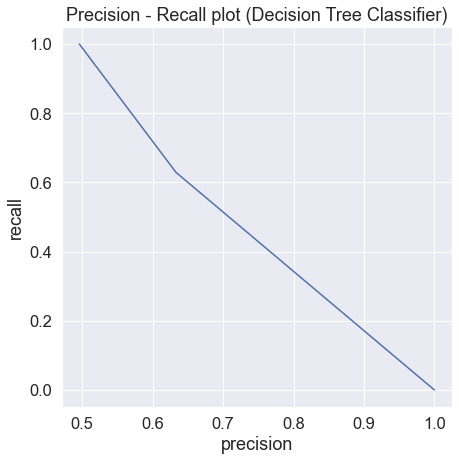

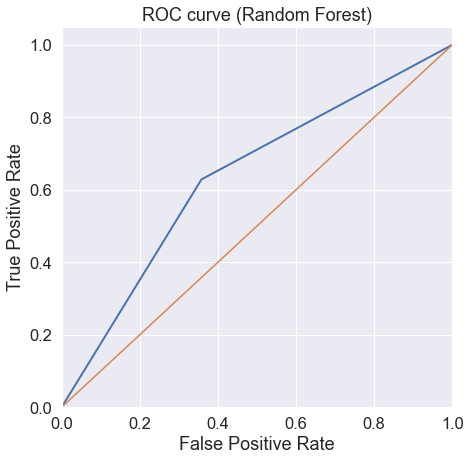

Confusion matrix, without normalization
[[5656 3164]
 [3219 5461]]


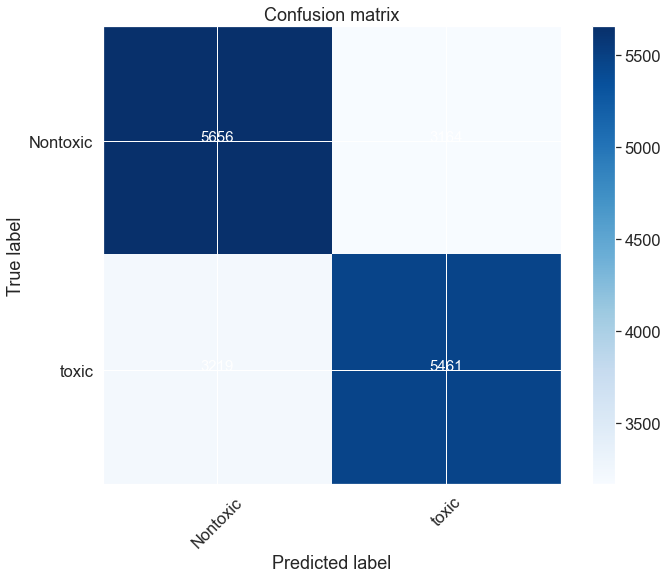

In [135]:
model_name = 'Decision Tree Classifier'
model_index = 1
model = classifiers[model_name]

#запустим кросс-валидацию
cv_score, cv_score_std = get_cross_validation_scores(model, X_train, y_train, cv=16, scoring='roc_auc')

#обучим пайплайн на всем тренировочном датасете
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

# выведем precision/recall plot
precision, recall, thresholds, f_score, ix = show_precision_recall_plot(y_test.values, y_pred, model_name)

# выведем roc_curve
get_roc_curve(y_test, y_pred, model_name)

# выведем матрицу ошибок
cnf_matrix = show_conf_matrix(y_test, y_pred, thresholds[ix])

# соберем всю статистику по модели в словарь
final_comparison['precision'].insert(model_index, round(precision[ix], 4))
final_comparison['precision'].pop(model_index+1)
final_comparison['recall'].insert(model_index, round(recall[ix], 4))
final_comparison['recall'].pop(model_index+1)
final_comparison['roc_auc'].insert(model_index, round(roc_auc_score(y_test, y_pred), 4))
final_comparison['roc_auc'].pop(model_index+1)
final_comparison['f_score'].insert(model_index, round(f_score[ix], 4))
final_comparison['f_score'].pop(model_index+1);

## Random Forest

CV score is 0.7734501681056019 +- 0.007171140345435727
Best Threshold = 0.35, F-Score = 0.719, Precision = 0.643, Recall = 0.816


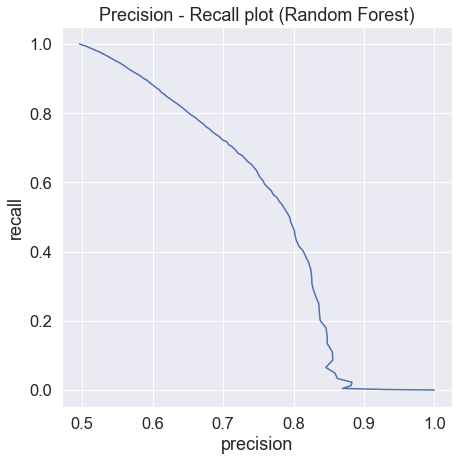

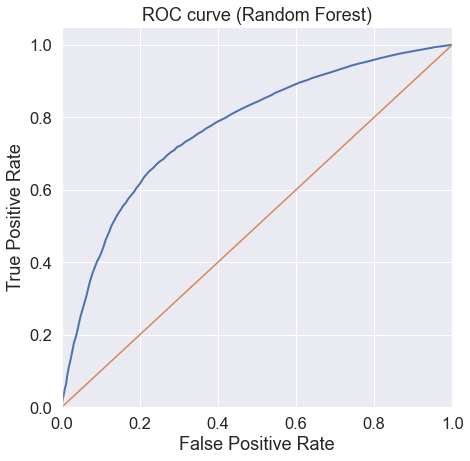

Confusion matrix, without normalization
[[4991 3829]
 [1663 7017]]


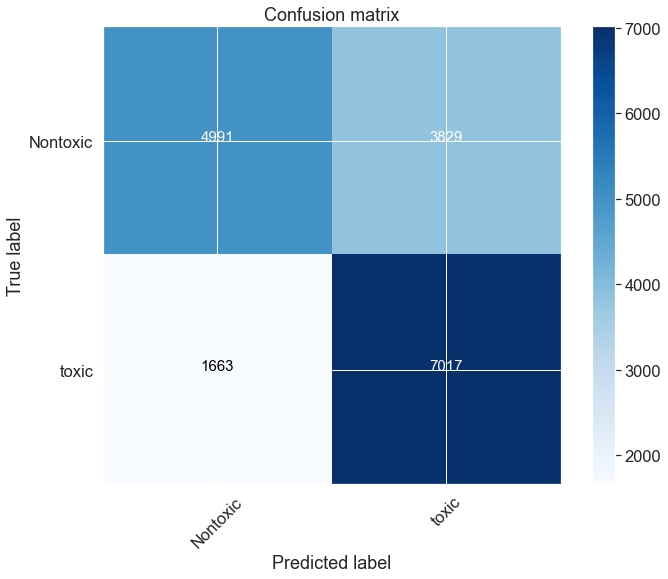

In [136]:
model_name = 'Random Forest'
model_index = 2
model = classifiers[model_name]

#запустим кросс-валидацию
cv_score, cv_score_std = get_cross_validation_scores(model, X_train, y_train, cv=16, scoring='roc_auc')

#обучим пайплайн на всем тренировочном датасете
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

# выведем precision/recall plot
precision, recall, thresholds, f_score, ix = show_precision_recall_plot(y_test.values, y_pred, model_name)

# выведем roc_curve
get_roc_curve(y_test, y_pred, model_name)

# выведем матрицу ошибок
cnf_matrix = show_conf_matrix(y_test, y_pred, thresholds[ix])

# соберем всю статистику по модели в словарь
final_comparison['precision'].insert(model_index, round(precision[ix], 4))
final_comparison['precision'].pop(model_index+1)
final_comparison['recall'].insert(model_index, round(recall[ix], 4))
final_comparison['recall'].pop(model_index+1)
final_comparison['roc_auc'].insert(model_index, round(roc_auc_score(y_test, y_pred), 4))
final_comparison['roc_auc'].pop(model_index+1)
final_comparison['f_score'].insert(model_index, round(f_score[ix], 4))
final_comparison['f_score'].pop(model_index+1);

## Gradient Boosting

CV score is 0.8025122195062337 +- 0.007075082499732897
Best Threshold = 0.39494659702686624, F-Score = 0.740, Precision = 0.698, Recall = 0.788


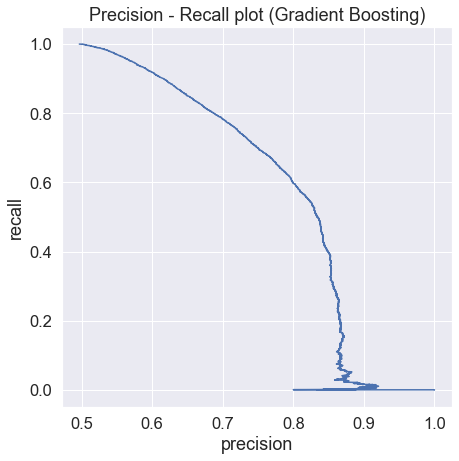

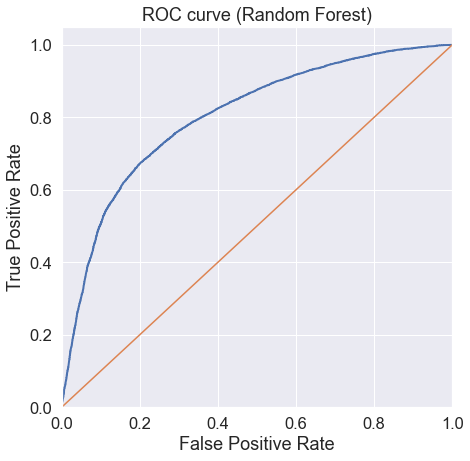

Confusion matrix, without normalization
[[5858 2962]
 [1840 6840]]


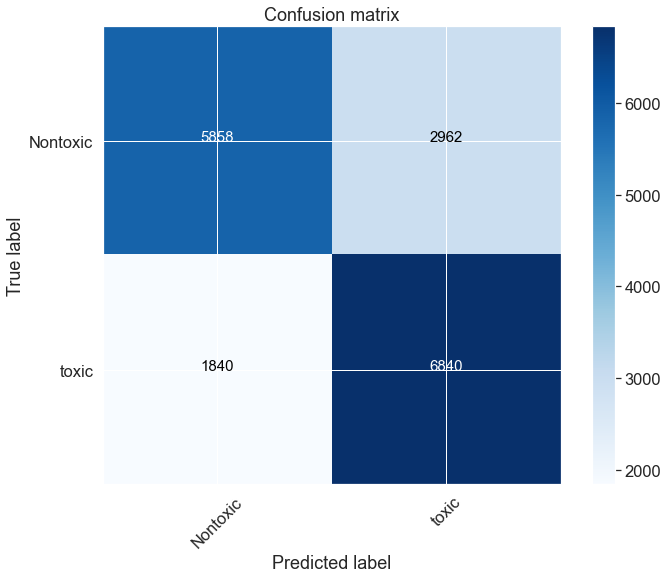

In [137]:
model_name = 'Gradient Boosting'
model_index = 3
model = classifiers[model_name]

#запустим кросс-валидацию
cv_score, cv_score_std = get_cross_validation_scores(model, X_train, y_train, cv=16, scoring='roc_auc')

#обучим пайплайн на всем тренировочном датасете
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

# выведем precision/recall plot
precision, recall, thresholds, f_score, ix = show_precision_recall_plot(y_test.values, y_pred, model_name)

# выведем roc_curve
get_roc_curve(y_test, y_pred, model_name)

# выведем матрицу ошибок
cnf_matrix = show_conf_matrix(y_test, y_pred, thresholds[ix])

# соберем всю статистику по модели в словарь
final_comparison['precision'].insert(model_index, round(precision[ix], 4))
final_comparison['precision'].pop(model_index+1)
final_comparison['recall'].insert(model_index, round(recall[ix], 4))
final_comparison['recall'].pop(model_index+1)
final_comparison['roc_auc'].insert(model_index, round(roc_auc_score(y_test, y_pred), 4))
final_comparison['roc_auc'].pop(model_index+1)
final_comparison['f_score'].insert(model_index, round(f_score[ix], 4))
final_comparison['f_score'].pop(model_index+1);

## Выводы о моделях:

In [140]:
df_results = pd.DataFrame(final_comparison)
df_results.set_index('models')

,precision,recall,roc_auc,f_score
models,,,,
Logistic Regression,0.6474,0.8376,0.7840,0.7303
Decision Tree Classifier,0.4960,1.0000,0.6353,0.6631
Random Forest,0.6427,0.8156,0.7710,0.7189
Gradient Boosting,0.6978,0.7881,0.8026,0.7402


"Внезапно", лучшая модель - это градиентный бустинг)  
  
У бустинга получился самый высокий precision, площадь под roc и сбалансированый f_score (без увеличения/уменьшения коэффициента бета)  
  
Все модели не настроены и взяты из коробки sklearn, не успеваю разобраться, как быстро встроить в пайплайн grid_search, думаю, это не критически в рамках этого урока  
  
Recall у бустинга не самый большой, можно было бы его подправить, если уменьшить бету, при подсчете f_score и в следствии выбрать другой трешолд

Также сами модели имеют по несколько гиперпараметров. У дерева - это глубина, кол-во листьев, минимальное кол-во значений в листках и др. У случайного леса - кол-во деревьев в лесу, использование бутстрап выборки и аут-оф-бег обучение (что убрало бы нужду использовать кросс-валидацию) и прочее, прочее, что я не успеваю сделать из-за дедлайнов в этом уроке)  
  
Настроив параметры, каждая модель могла бы показать результаты получше)

## precision/recall vs roc_auc
(with disbalanced classes)

Пришлось сначала подумать, а потом погуглить над этим вопросом. Мы до этого не строили precision/recall графики, УЖЕ ПО ОЧЕВИДНЫМ причинам)) Достаточно тяжело их интерпретировать, так как они сильно зависят от дисбаланса классов  
  
У roc кривой происходит разбиение "сетки" графика по кол-ву представителей класса, снизу будет m условных единиц, где m - кол-во истинных единиц. А по вертикали сетка будет разбита на n сегментов, где m - кол-во истинных нулей. При это весь график будет в пределах от 0 до 1, я говорю о сетке "лесенки", которую по сути каждая roc кривая из себя представляет
  
Таким образом, каков бы ни был дисбаланс классов - самая плохая модель будет та, которая предскажет все одним классом и проведет диагональ из нижнего левого угла, в правый верхний. Происходит это именно из-за того что считаются fpr/tpr, которые по сути, включают в себя дисбаланс классов, учитывая все клетки матрицы ошибок  
  
А вот при подсчете precision/recall совсем не учитывается TN значения матрицы ошибок. Что делает график "сплющеным" при дизбалансе классов. И худшая модель на таком графике - не так просто понятно как будет выглядеть)  
  
Очень помогла вот эта [статья](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/), в ней просто показаны графики обоих метрик при дизбалансе классов, если на них посмотреть - сразу становится все очевидно :)

***
  
Ответ на последний вопрос из домашки, какая модель лучше (та которая предсказала 100 единиц + TP = 90, или та, которая предсказала 1000 единиц + TP = 90)  
  
Лучше первая, так как ее пресижн будет 0.9, а у второй пресижн будет 0.09  
  
Кроме того, false positive rate у второй модели будет в ~90 раз больше  
  
И мы уже выяснили, что ориентируясь на графики, roc кривая перваой модели включалабы бОльшую площадь под собой, чем roc кривая второй модели. График precision/recall тоже имел бы бОльшую площадь у первой модели, но это было бы практически не заметно "на глаз", потому что не понятно, как выглядит самая плохая модель на таком графике.